In [2]:
import numpy as np
from scipy.io import loadmat
import os
from hmmlearn import hmm


In [3]:
def fix_mat(data):
    if data.dtype.names:
        new_data = dict()
        for name in data.dtype.names:
            new_data[name]=data[0][name][0]
        for k,v in new_data.items():
            if v.dtype.names:
                new_data[k] = fix_mat(v)
            else:
                new_data[k] = np.squeeze(v)
        return new_data
    else:
        return data

In [4]:
path = '/home/paolo/cvsa_ws/src/analysis_cvsa/hmm/gaussian_hmm.mat'
data = loadmat(path)

In [5]:
eeg_data_train = fix_mat(data['X_train'])
T_train = fix_mat(data['T_train'])

eeg_data_test = fix_mat(data['X_test'])
T_test = fix_mat(data['T_test'])

In [6]:
# Create a Gaussian HMM model
n_state = 3
model = hmm.GaussianHMM(n_components=n_state, covariance_type='diag', n_iter=1000, verbose=True)
model.fit(eeg_data_train)

         1 -370586.05768223             +nan
         2 -175512.70152442 +195073.35615780
         3  -53785.01004131 +121727.69148311
         4  -12307.13705598  +41477.87298533
         5   -9571.80983499   +2735.32722100
         6   -8630.90716337    +940.90267162
         7   -8338.38038777    +292.52677560
         8   -8224.40720317    +113.97318460
         9   -8130.54597404     +93.86122913
        10   -8066.71490760     +63.83106644
        11   -8023.02938534     +43.68552226
        12   -7993.68658306     +29.34280228
        13   -7976.88477001     +16.80181305
        14   -7970.66614132      +6.21862869
        15   -7968.33311404      +2.33302727
        16   -7967.40993540      +0.92317864
        17   -7967.03194343      +0.37799198
        18   -7966.87334515      +0.15859828
        19   -7966.80560124      +0.06774391
        20   -7966.77628479      +0.02931645
        21   -7966.76347528      +0.01280951
        22   -7966.75783698      +0.00563830


GaussianHMM(n_components=3, n_iter=1000, verbose=True)

In [7]:
# Most likely state sequence
vpath = model.predict(eeg_data_train)

# Posterior probabilities (Gamma)
Gamma = model.predict_proba(eeg_data_train)

# Transition matrix
A = model.transmat_

# Means and covariances
means = model.means_            # shape: [n_states, n_features]
covars = model.covars_          # shape: [n_states, n_features, n_features]

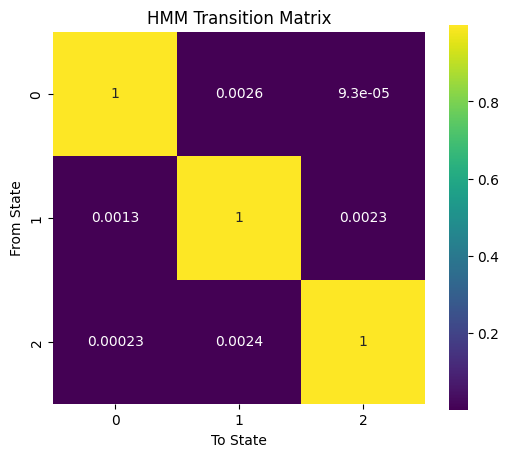

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 5))
sns.heatmap(A, annot=True, cmap='viridis', square=True)
plt.title("HMM Transition Matrix")
plt.xlabel("To State")
plt.ylabel("From State")
plt.show()


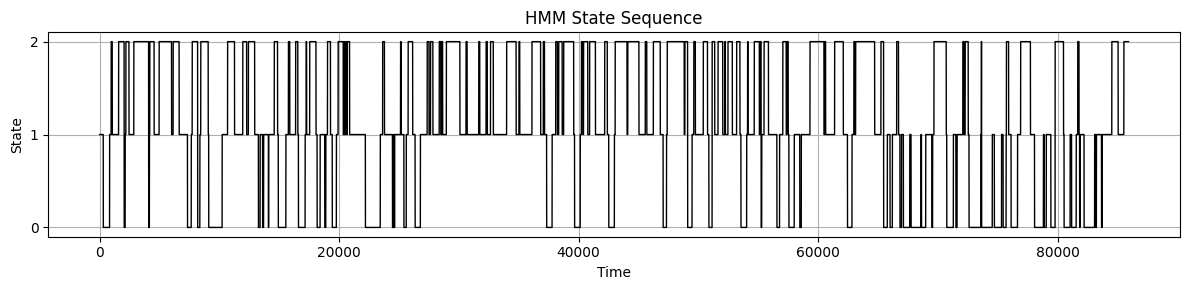

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 3))
plt.plot(vpath, lw=1, color='black')
plt.title("HMM State Sequence")
plt.xlabel("Time")
plt.ylabel("State")
plt.yticks(range(model.n_components))
plt.grid(True)
plt.tight_layout()
plt.show()


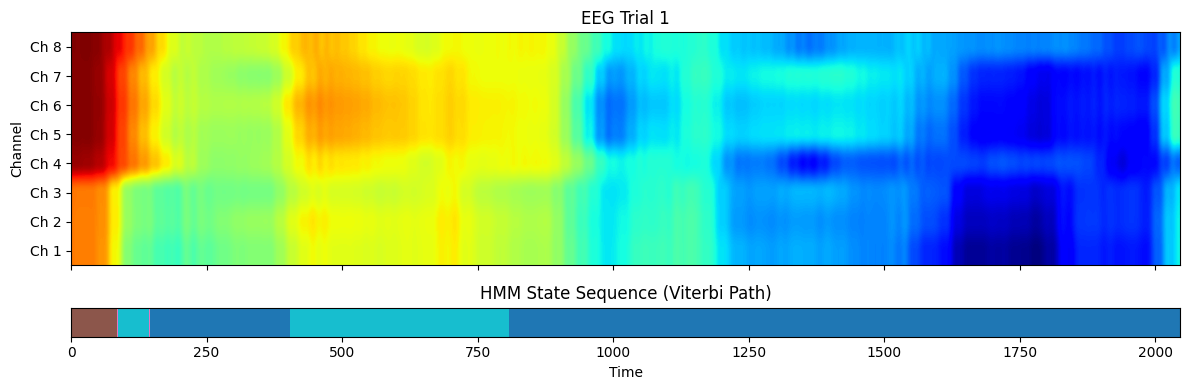

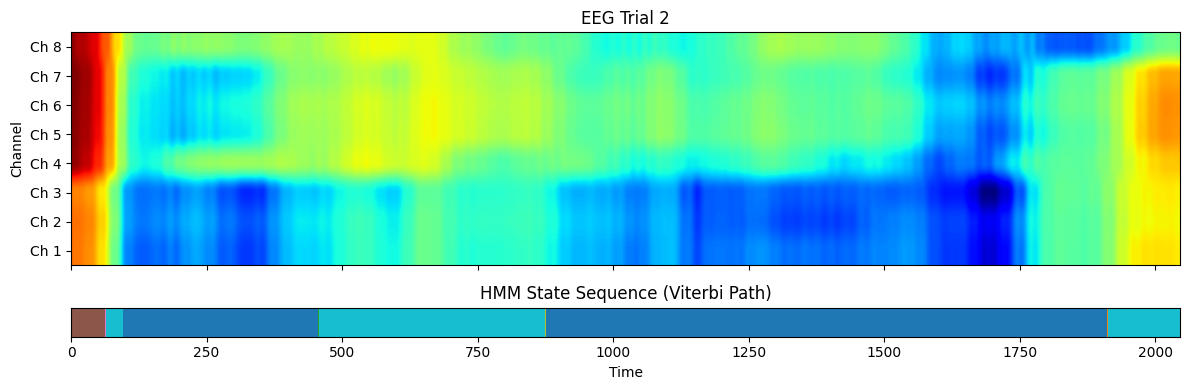

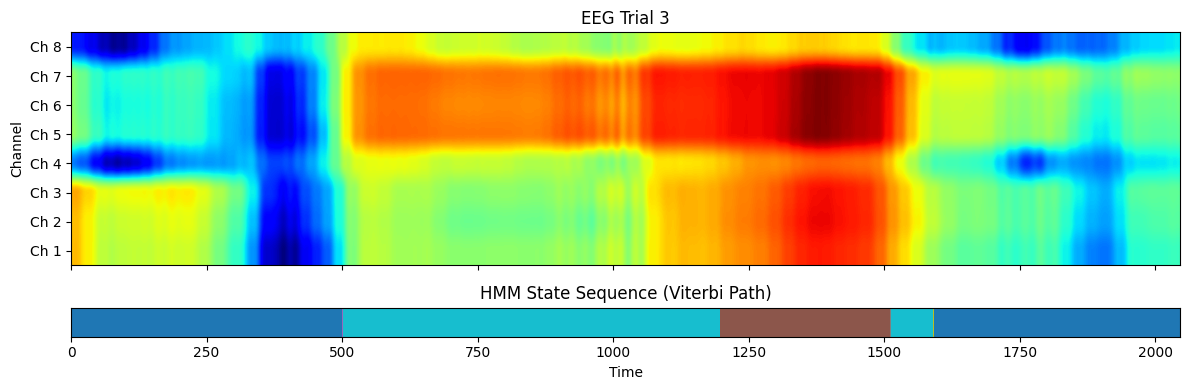

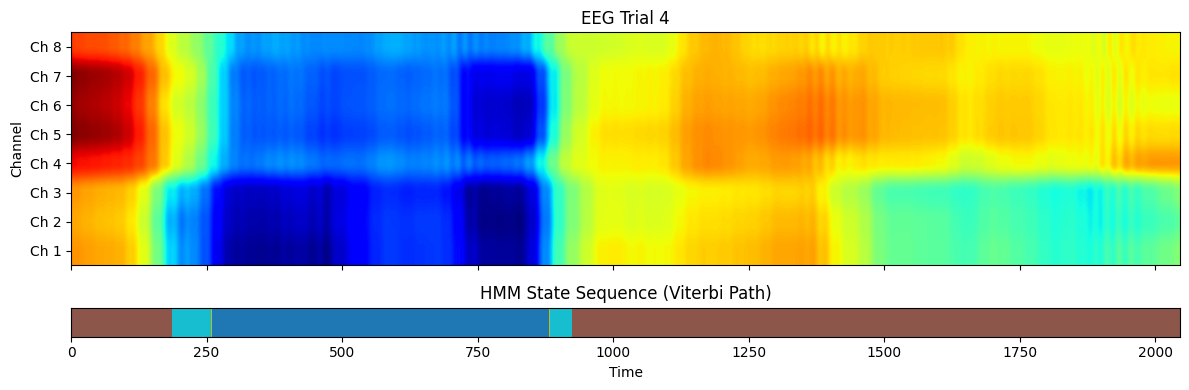

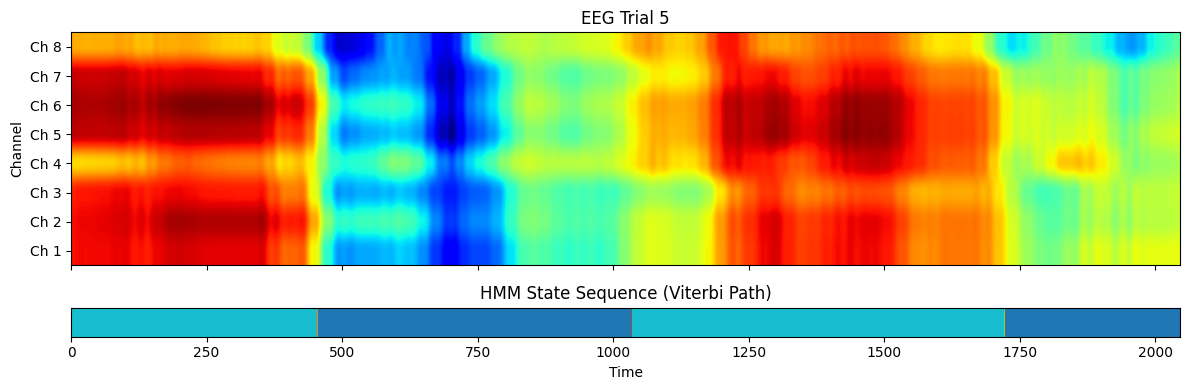

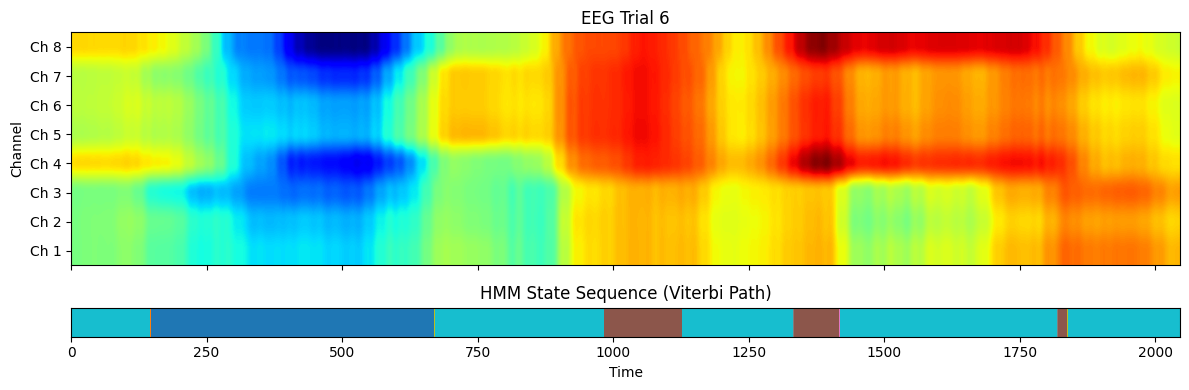

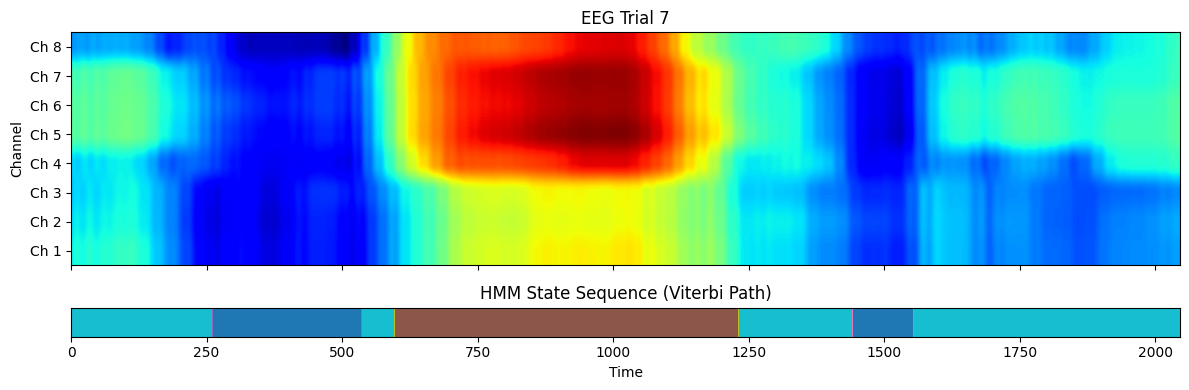

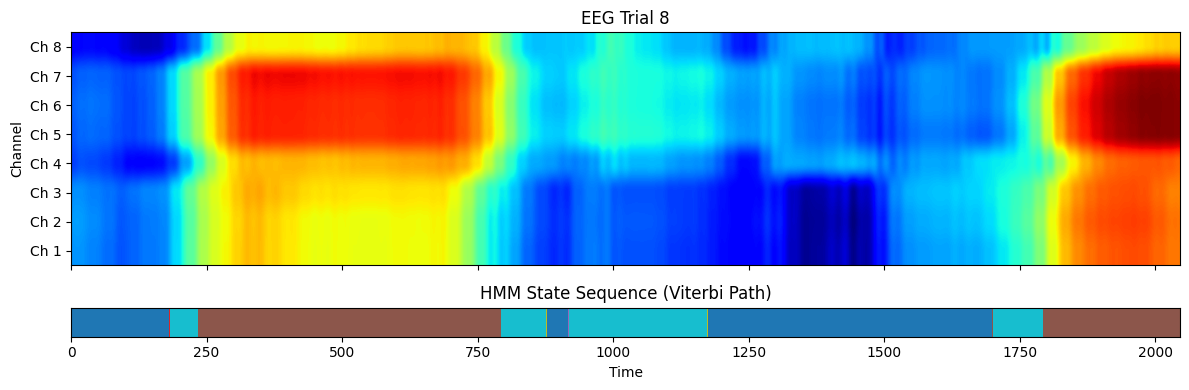

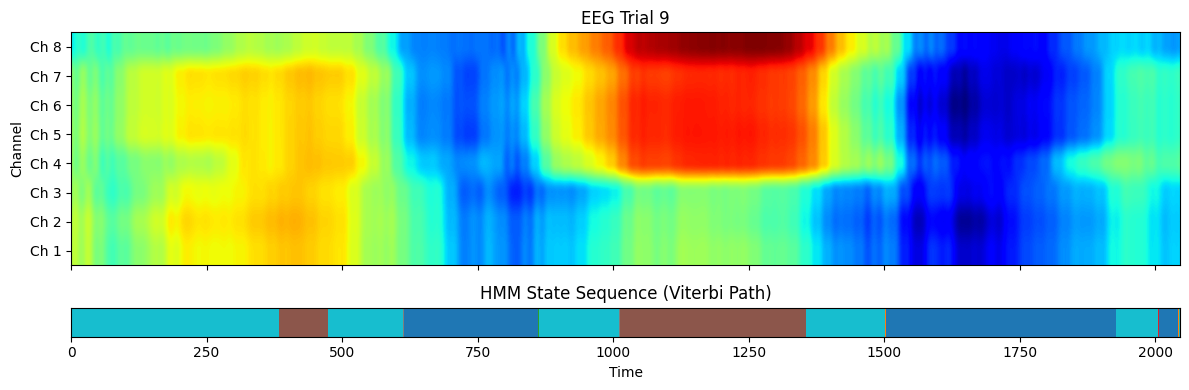

KeyboardInterrupt: 

<Figure size 1200x400 with 0 Axes>

In [27]:
import matplotlib.pyplot as plt
import numpy as np

trial_lengths = T_train
cumsum_lengths = np.cumsum([0] + trial_lengths)

for i in range(len(trial_lengths)):
    start = int(cumsum_lengths[i])
    end = int(cumsum_lengths[i + 1])
    
    eeg_trial = eeg_data_train[start:end, :].T       # [channels, time]
    vpath_trial = vpath[start:end]             # [time]
    n_timepoints = eeg_trial.shape[1]

    fig, axs = plt.subplots(2, 1, figsize=(12, 4), sharex=True,
                            gridspec_kw={'height_ratios': [8, 1]})

    # EEG heatmap
    im = axs[0].imshow(eeg_trial, aspect='auto', cmap='jet', origin='lower',
                       extent=[0, n_timepoints, 0, eeg_trial.shape[0]])
    axs[0].set_title(f"EEG Trial {i+1}")
    axs[0].set_ylabel("Channel")
    axs[0].set_yticks(np.arange(eeg_trial.shape[0]) + 0.5)
    axs[0].set_yticklabels([f'Ch {i+1}' for i in range(eeg_trial.shape[0])])
    #plt.colorbar(im, ax=axs[0], orientation='vertical', label='Amplitude')

    # Viterbi path bar
    axs[1].imshow(vpath_trial[None, :], aspect='auto', cmap='tab10',
                  extent=[0, n_timepoints, 0, 1])
    axs[1].set_yticks([])
    axs[1].set_xlabel("Time")
    axs[1].set_title("HMM State Sequence (Viterbi Path)")

    plt.tight_layout()
    plt.show()

In [8]:
from sklearn.cluster import KMeans

n_clusters = 3  # or any number you want
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(eeg_data_train)  # shape: [total_samples]

test_labels = kmeans.predict(eeg_data_test)  # shape: [total_samples_test]

/home/paolo/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


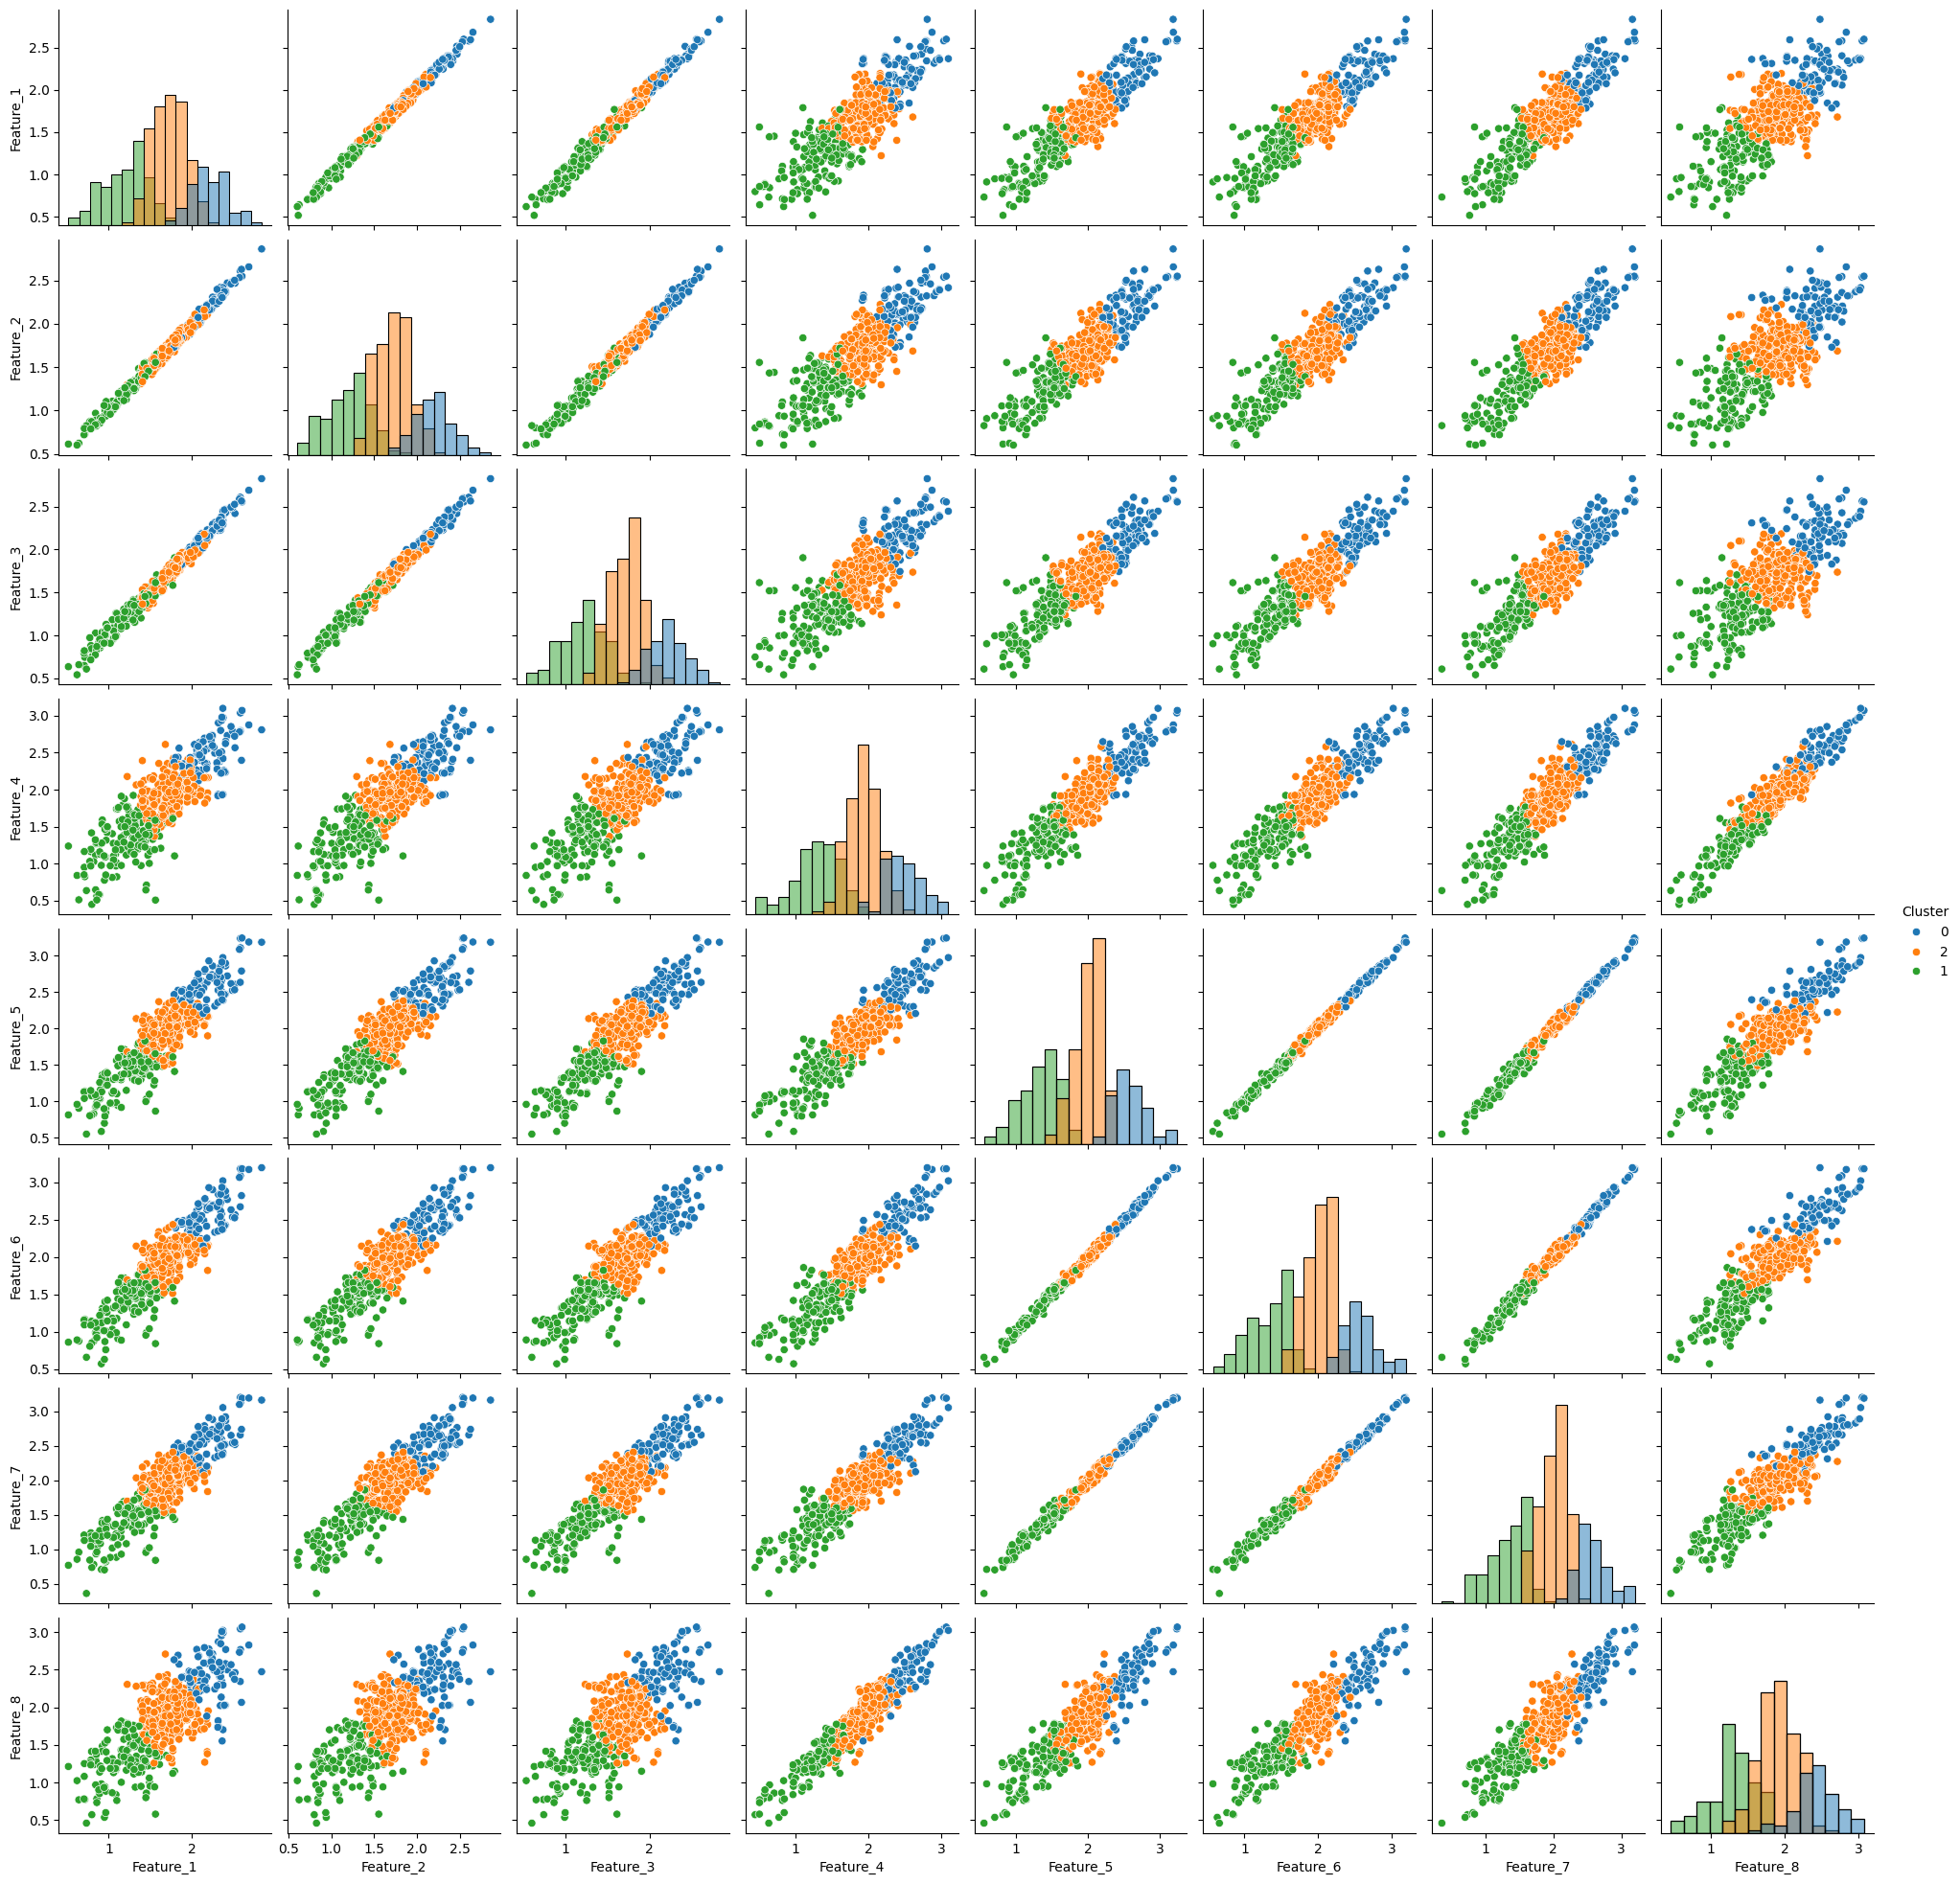

In [10]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(eeg_data_train, columns=[f"Feature_{i+1}" for i in range(eeg_data_train.shape[1])])
df['Cluster'] = labels.astype(str)  # Convert to string for color coding

df_sampled = df.sample(n=500, random_state=42)
sns.pairplot(df_sampled, hue="Cluster", diag_kind="hist")

# Plot pairplot
#sns.pairplot(df, hue="Cluster", palette="tab10", diag_kind="hist")

In [23]:
test_labels

array([2, 2, 2, ..., 1, 1, 1], dtype=int32)

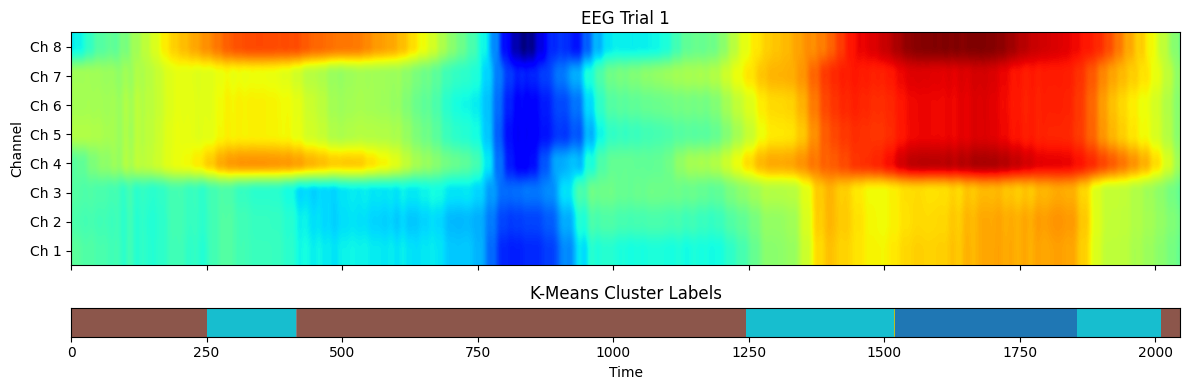

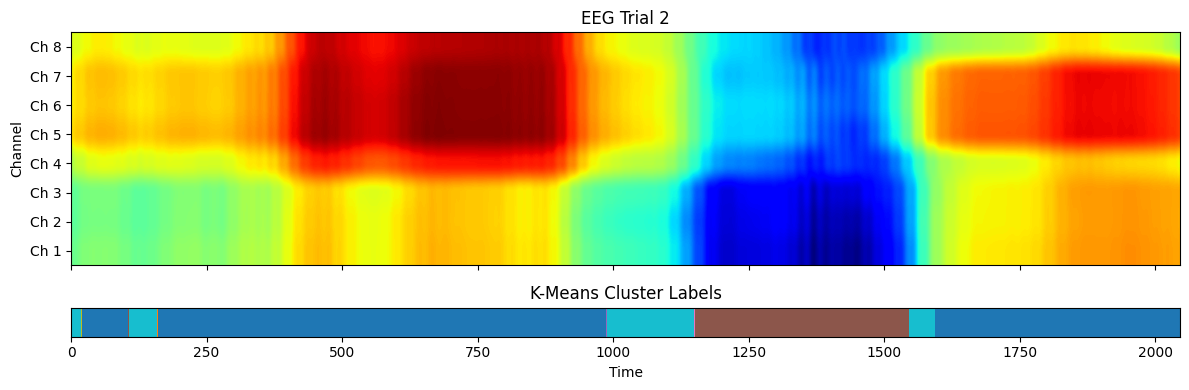

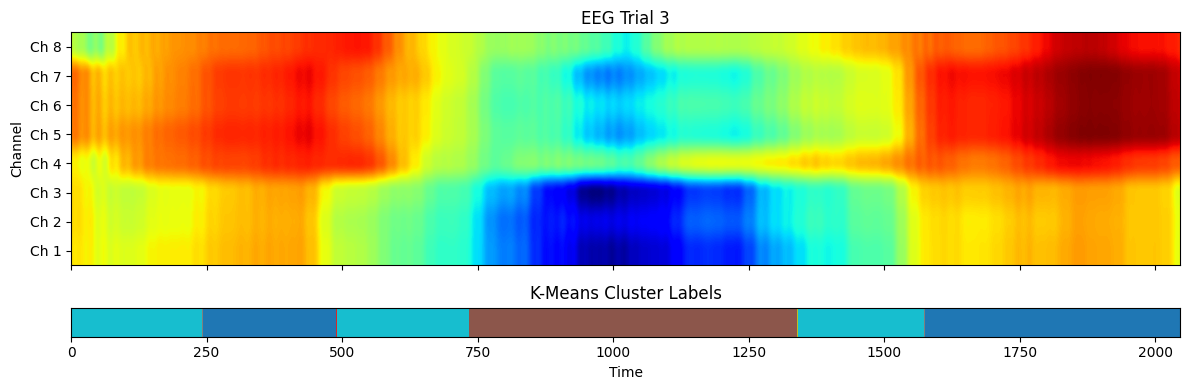

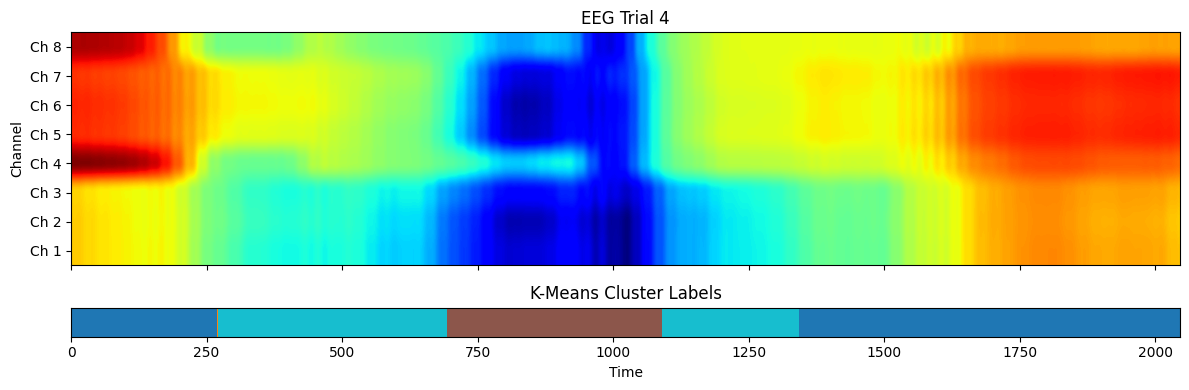

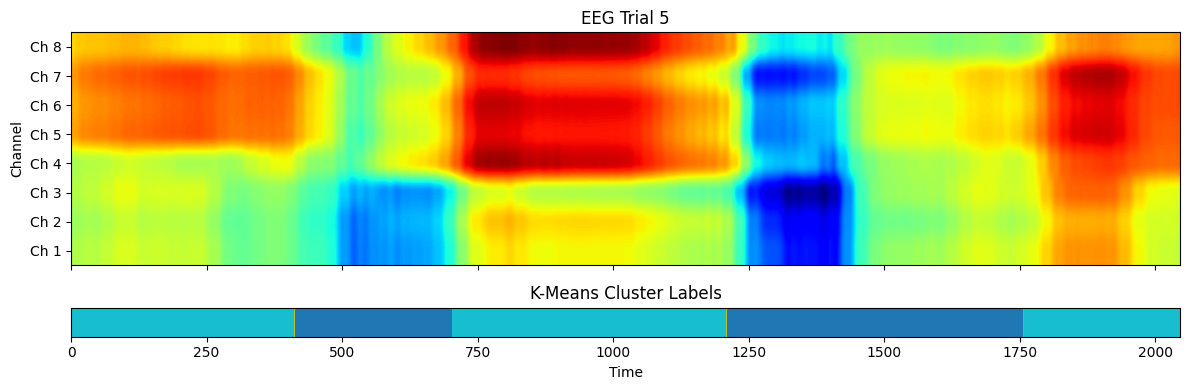

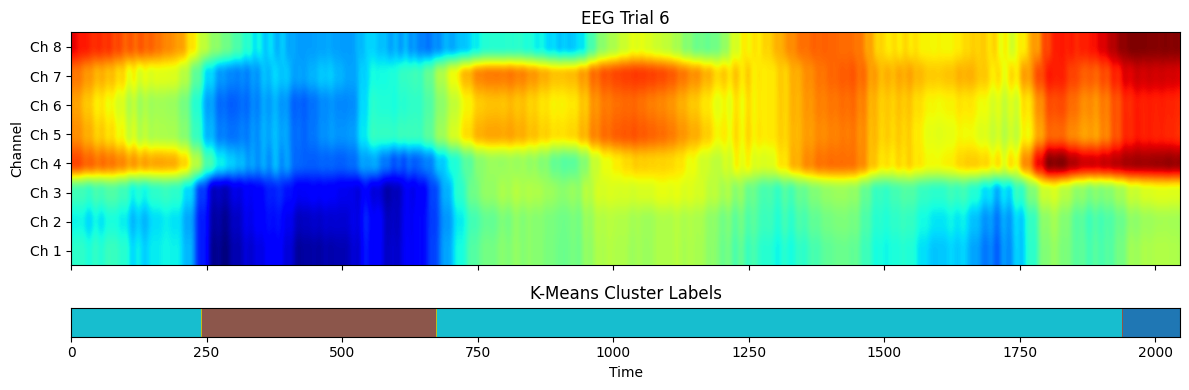

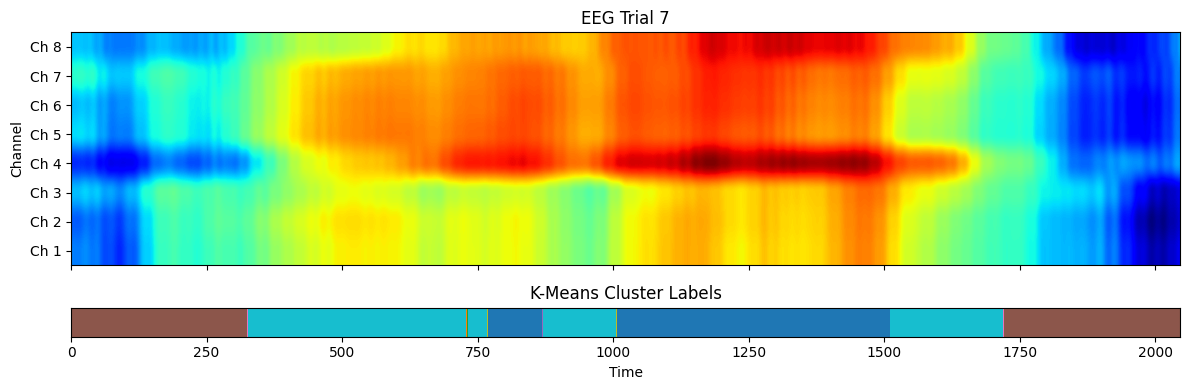

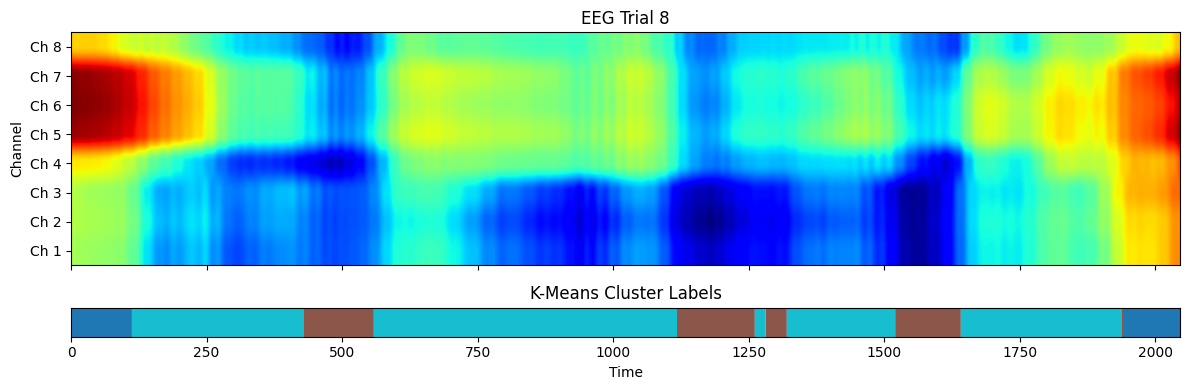

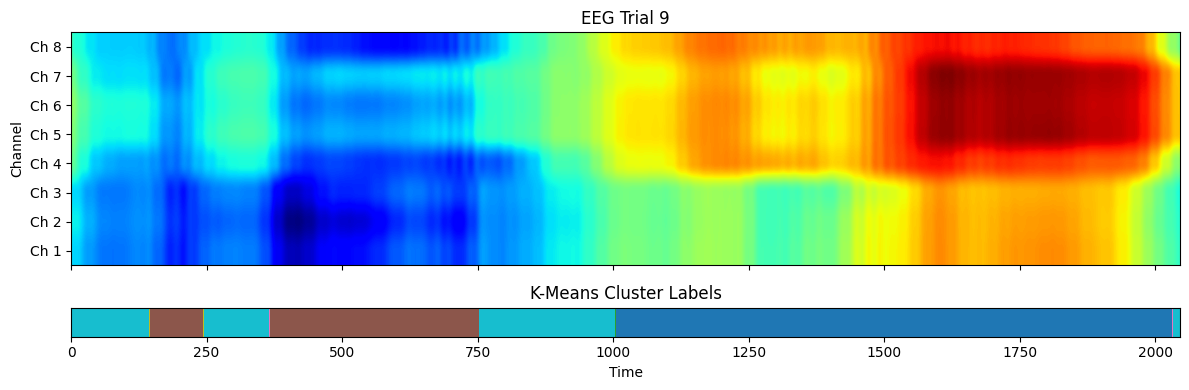

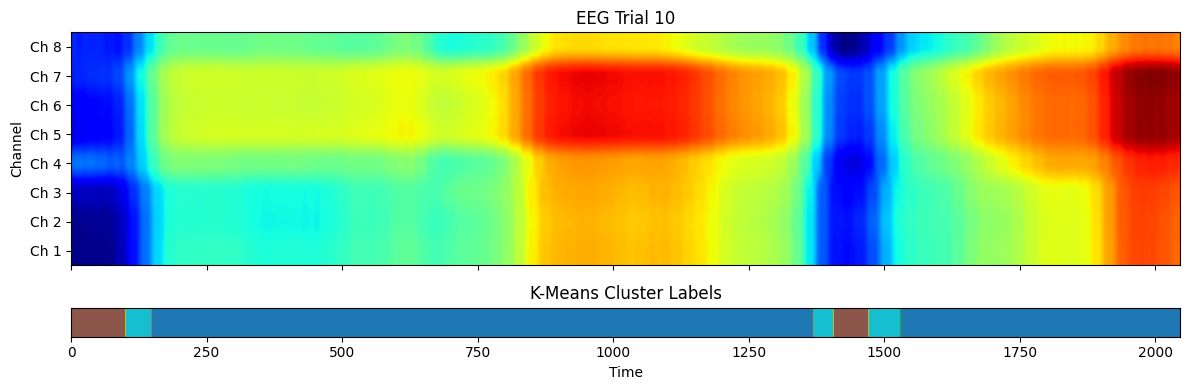

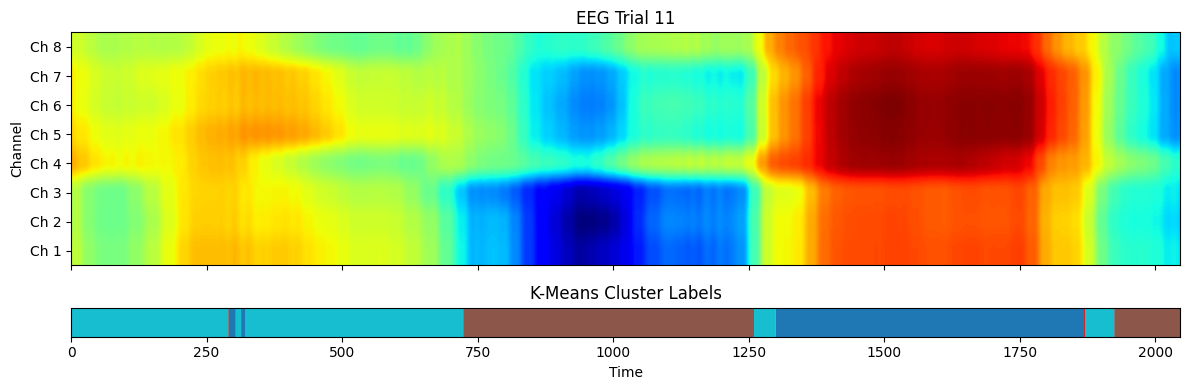

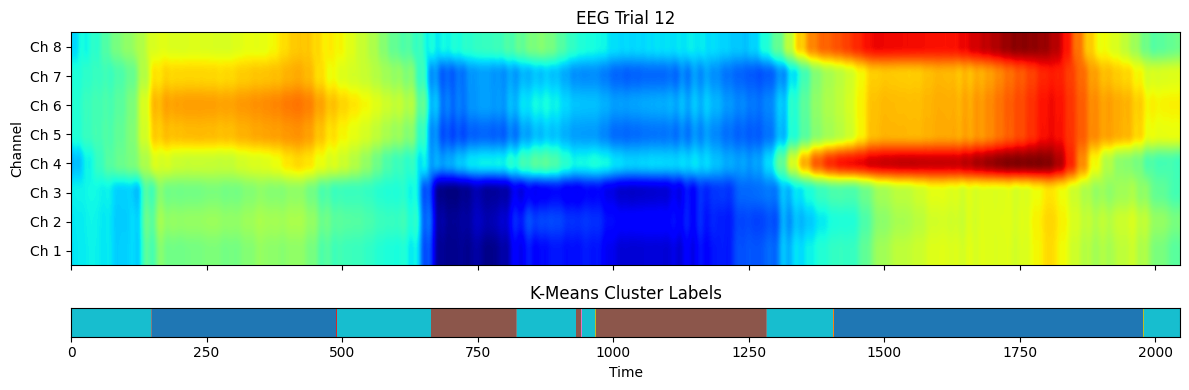

KeyboardInterrupt: 

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

trial_lengths = T_train
cumsum_lengths = np.cumsum([0] + trial_lengths)

for i in range(len(trial_lengths)):
    start = cumsum_lengths[i]
    end = cumsum_lengths[i + 1]
    
    eeg_trial = eeg_data_test[int(start):int(end), :].T       # [channels, time]
    cluster_labels_trial = test_labels[int(start):int(end)]   # [time]
    n_timepoints = eeg_trial.shape[1]

    fig, axs = plt.subplots(2, 1, figsize=(12, 4), sharex=True,
                            gridspec_kw={'height_ratios': [8, 1]})

    im = axs[0].imshow(eeg_trial, aspect='auto', cmap='jet', origin='lower',
                       extent=[0, n_timepoints, 0, eeg_trial.shape[0]])
    axs[0].set_title(f"EEG Trial {i+1}")
    axs[0].set_ylabel("Channel")
    axs[0].set_yticks(np.arange(eeg_trial.shape[0]) + 0.5)
    axs[0].set_yticklabels([f'Ch {i+1}' for i in range(eeg_trial.shape[0])])
    #plt.colorbar(im, ax=axs[0], orientation='vertical', label='Amplitude')

    axs[1].imshow(cluster_labels_trial[None, :], aspect='auto', cmap='tab10',
                  extent=[0, n_timepoints, 0, 1])
    axs[1].set_yticks([])
    axs[1].set_xlabel("Time")
    axs[1].set_title("K-Means Cluster Labels")

    plt.tight_layout()
    plt.show()
